**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Write your code here

import numpy as np
import pandas as pd

from scipy.optimize import minimize, fsolve, minimize_scalar

from types import SimpleNamespace
import matplotlib.pyplot as plt

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
w = 1.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1


In [3]:
# Supporting functions
def labor_demand(p, A, gamma, w):
    # Calculate the labor demand given price, productivity, gamma, and wage rate
    return (p * A * gamma / w) ** (1 / (1 - gamma))

def output(p, A, gamma, w):
    # Calculate the output using the labor demand
    l = labor_demand(p, A, gamma, w)
    return A * l ** gamma

def profit(p, A, gamma, w):
    # Calculate the profit using price, productivity, gamma, and wage rate
    l = labor_demand(p, A, gamma, w)
    y = output(p, A, gamma, w)
    return p * y - w * l

def utility(p1, p2, w, tau, T, A, gamma, alpha, nu, epsilon):
    # Calculate utility and optimize labor supply
    def obj(l):
        pi1 = profit(p1, A, gamma, w)
        pi2 = profit(p2, A, gamma, w)
        budget = w * l + T + pi1 + pi2
        c1 = alpha * budget / p1
        c2 = (1 - alpha) * budget / (p2 + tau)
        U = np.log(c1 ** alpha * c2 ** (1 - alpha)) - nu * l ** (1 + epsilon) / (1 + epsilon)
        return -U  # negative utility for minimization

    result = minimize_scalar(obj, bounds=(0, 100), method='bounded')
    l_star = result.x
    pi1 = profit(p1, A, gamma, w)
    pi2 = profit(p2, A, gamma, w)
    budget = w * l_star + T + pi1 + pi2
    c1_star = alpha * budget / p1
    c2_star = (1 - alpha) * budget / (p2 + tau)
    return c1_star, c2_star, l_star

# Prices for good 1 and good 2
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)

# Check market clearing conditions for different price combinations
market_clearing_results = []
for p1 in p1_values:
    for p2 in p2_values:
        c1_star, c2_star, l_star = utility(p1, p2, w, par.tau, par.T, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
        l1_star = labor_demand(p1, par.A, par.gamma, w)
        l2_star = labor_demand(p2, par.A, par.gamma, w)
        y1_star = output(p1, par.A, par.gamma, w)
        y2_star = output(p2, par.A, par.gamma, w)

        # Check if labor market and goods markets clear
        labor_market_clears = np.isclose(l_star, l1_star + l2_star)
        good_market_1_clears = np.isclose(c1_star, y1_star)
        good_market_2_clears = np.isclose(c2_star, y2_star)

        result = {
            'p1': p1, 'p2': p2,
            'labor_market_clears': labor_market_clears,
            'good_market_1_clears': good_market_1_clears,
            'good_market_2_clears': good_market_2_clears,
            'labor_market_clearing': l_star - (l1_star + l2_star),
            'good1_market_clearing': c1_star - y1_star,
            'good2_market_clearing': c2_star - y2_star
        }
        market_clearing_results.append(result)

# # Convert the results to a DataFrame for better visualization
# results_df = pd.DataFrame(market_clearing_results)

# # Apply formatting to all float columns for readability
# results_df = results_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, float) else x)

# # Display the DataFrame using IPython display
# display(results_df)


# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(market_clearing_results)

# Apply formatting to all float columns for readability
float_columns = results_df.select_dtypes(include=['float']).columns
results_df[float_columns] = results_df[float_columns].applymap(lambda x: f"{x:.4f}")

# Display the DataFrame using IPython display
display(results_df)

# Another check for market clearing conditions, only store successful cases
market_clearing_results1 = []
for p1 in p1_values:
    for p2 in p2_values:
        c1_star, c2_star, l_star = utility(p1, p2, w, par.tau, par.T, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
        l1_star = labor_demand(p1, par.A, par.gamma, w)
        l2_star = labor_demand(p2, par.A, par.gamma, w)
        y1_star = output(p1, par.A, par.gamma, w)
        y2_star = output(p2, par.A, par.gamma, w)

        # Check conditions again
        labor_market_clears = np.isclose(l_star, l1_star + l2_star)
        good_market_1_clears = np.isclose(c1_star, y1_star)
        good_market_2_clears = np.isclose(c2_star, y2_star)

        if labor_market_clears and good_market_1_clears and good_market_2_clears:
            result = {
                'p1': p1, 'p2': p2, 'labor_market': labor_market_clears,
                'good_market_1': good_market_1_clears, 'good_market_2': good_market_2_clears
            }
            market_clearing_results1.append(result)

# Print results for combinations where market clearing conditions are met
if market_clearing_results1:
    print("Market clearing conditions are met for the following price combinations:")
    for result in market_clearing_results1:
        print(result)
else:
    print("No market clearing conditions were met within the given price intervals.")


,p1,p2,labor_market_clears,good_market_1_clears,good_market_2_clears,labor_market_clearing,good1_market_clearing,good2_market_clearing
0,0.1000,0.1000,False,False,False,0.9933,2.9600,6.9734
1,0.1000,0.3111,False,False,False,0.9645,3.0036,2.1347
2,0.1000,0.5222,False,False,False,0.9063,3.0930,1.1432
3,0.1000,0.7333,False,False,False,0.8194,3.2299,0.6770
4,0.1000,0.9444,False,False,False,0.7047,3.4171,0.3844
...,...,...,...,...,...,...,...,...
95,2.0000,1.1556,False,False,False,-0.6328,-0.6948,0.6549
96,2.0000,1.3667,False,False,False,-0.7848,-0.6776,0.4174
97,2.0000,1.5778,False,False,False,-0.9607,-0.6574,0.2244
98,2.0000,1.7889,False,False,False,-1.1599,-0.6340,0.0604


No market clearing conditions were met within the given price intervals.


The findings of the previous cell indicate that the labor market, as well as the markets for goods 1 and 2, do not clear. This means that there is an imbalance between the demand and supply in these markets. You are also welcome to browse our dataframe. 


**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [4]:
# Definitions of the model's functions

def labor_demand(p, A, gamma, w):
    # Calculates the labor demand based on price, productivity, gamma, and wage rate
    return (p * A * gamma / w) ** (1 / (1 - gamma))

def output(p, A, gamma, w):
    # Calculates the output using the labor demand
    l = labor_demand(p, A, gamma, w)
    return A * l ** gamma

def profit(p, A, gamma, w):
    # Calculates the profit based on price, productivity, gamma, and wage rate
    l = labor_demand(p, A, gamma, w)
    y = output(p, A, gamma, w)
    return p * y - w * l

def goods_market_clearing(prices):
    # Determines if the goods markets clear for given prices
    p1, p2 = prices
    # Calculate utility, output for goods 1 and 2
    c1_star, c2_star, l_star = utility(p1, p2, w, par.tau, par.T, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
    y1_star = output(p1, par.A, par.gamma, w)
    y2_star = output(p2, par.A, par.gamma, w)
    
    # Calculate the market clearing conditions for goods 1 and 2
    clear_good1 = c1_star - y1_star
    clear_good2 = c2_star - y2_star
    
    return [clear_good1, clear_good2]

# Root finding for equilibrium prices
initial_guess = [1.0, 1.0]  # Initial guess for prices p1 and p2
equilibrium_prices = fsolve(goods_market_clearing, initial_guess)

# Print the equilibrium prices
print(f"Equilibrium prices are p1 = {equilibrium_prices[0]:.4f}, p2 = {equilibrium_prices[1]:.4f}")


Equilibrium prices are p1 = 0.9759, p2 = 1.4908


The equilibrium prices are presented above. Since they are not found in the linspace above we do not find that the market clearing conditions are satisfied in q.1. Note that prices are in accordance with our a priori expectation since $\alpha<1-alpha$. 

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

Optimal tau: 0.13671402186939574
Equilibrium prices with optimal tau: [0.95640298 1.39417101]
Implied optimal T: 0.09530136325571639
Social Welfare for tau = 0: -0.6621612864598336
Social Welfare for optimal tau: -0.6596933786135991


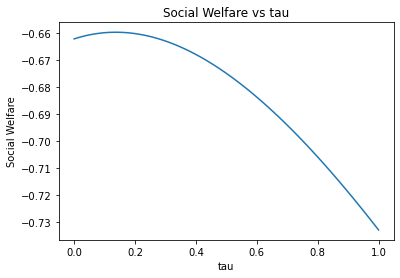

In [5]:
# We define a function to find equilibrium prices given a tax rate tau
def find_equilibrium_prices(tau, initial_guess=[1.0, 1.0]):
    def equilibrium_conditions(prices):
        p1, p2 = prices
        # We calculate utility, output for goods 1 and 2 with given prices and tau
        c1_star, c2_star, l_star = utility(p1, p2, w, tau, 0, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
        y1_star = output(p1, par.A, par.gamma, w)
        y2_star = output(p2, par.A, par.gamma, w)
        # We return the differences between consumption and output to find equilibrium
        return np.array([c1_star - y1_star, c2_star - y2_star]).flatten()
    return fsolve(equilibrium_conditions, initial_guess)

# We define a function to optimize social welfare given a tax rate tau
def swf_optimization(tau):
    # We find equilibrium prices for the given tau
    p1, p2 = find_equilibrium_prices(tau)
    # We calculate utility for the equilibrium prices and tau
    c1_star, c2_star, l_star = utility(p1, p2, w, tau, 0, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
    T = tau * c2_star  # We calculate lump-sum transfer T
    # We recalculate utility considering the transfer T
    c1_star, c2_star, l_star = utility(p1, p2, w, tau, T, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
    y2_star = output(p2, par.A, par.gamma, w)
    # We calculate the social welfare function (SWF)
    U = np.log(c1_star ** par.alpha * c2_star ** (1 - par.alpha)) - par.nu * l_star ** (1 + par.epsilon) / (1 + par.epsilon)
    SWF = U - par.kappa * y2_star
    return -SWF  # We return negative SWF for minimization

# We perform numerical optimization to find the optimal tax rate tau
opt_result = minimize(lambda tau: swf_optimization(tau), 0.1, bounds=[(0, None)], method='L-BFGS-B')
optimal_tau = opt_result.x[0]  # We find the optimal tau value
optimal_prices = find_equilibrium_prices(optimal_tau)  # We find equilibrium prices for the optimal tau

# We complete the utility function call to get c2_star for optimal tau
_, optimal_c2_star, _ = utility(optimal_prices[0], optimal_prices[1], w, optimal_tau, 0, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
optimal_T = optimal_tau * optimal_c2_star  # We calculate the lump-sum transfer T using the correct c2_star

# We calculate social welfare for tau = 0
swf_tau_0 = -swf_optimization(0.0)

# We calculate social welfare for the optimal tau
swf_optimal_tau = -swf_optimization(optimal_tau)

# We print the results
print(f"Optimal tau: {optimal_tau}")
print(f"Equilibrium prices with optimal tau: {optimal_prices}")
print(f"Implied optimal T: {optimal_T}")
print(f"Social Welfare for tau = 0: {swf_tau_0}")
print(f"Social Welfare for optimal tau: {swf_optimal_tau}")

# We calculate social welfare for different values of tau
tau_values = np.linspace(0, 1, 100)
swf_values = [-swf_optimization(tau) for tau in tau_values]

# We plot social welfare vs tau
plt.plot(tau_values, swf_values)
plt.xlabel('tau')
plt.ylabel('Social Welfare')
plt.title('Social Welfare vs tau')
plt.show()


As presented above the government should choose $\tau$ of 0.137.  This leads to less consumption of the harmful good $y_2$. Furthermore, since demand and supply is non-perfectly inelastic, the net producer price is lower. Also, $ SWF_{\tau=0}< SWF_{\tau=0.137}$, which is as we would expect.

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [6]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000
par.F = np.arange(1,par.N+1)
par.sigma = 2
par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [7]:
# Set the random seed for reproducibility
np.random.seed(1312)

# Generate all epsilon values at once using a normal distribution
epsilon = np.random.normal(0, par.sigma, (par.K, par.J))

# Function to calculate expected utility and average realized utility using pre-generated epsilon values
def calculate_utilities(par, epsilon):
    # Initialize arrays to store expected utilities and average realized utilities for each career track
    expected_utilities = np.zeros(par.J)
    average_realized_utilities = np.zeros(par.J)
    
    for j in range(par.J):
        # Use the pre-generated epsilon values for each career track
        epsilons = epsilon[:, j]
        
        # Calculate the expected utility for career track j
        expected_utilities[j] = par.v[j] + np.mean(epsilons)
        
        # Calculate the average realized utility for career track j
        realized_utilities = par.v[j] + epsilons
        average_realized_utilities[j] = np.mean(realized_utilities)
    
    return expected_utilities, average_realized_utilities

# Calculate the expected utilities and average realized utilities
expected_utilities, average_realized_utilities = calculate_utilities(par, epsilon)

# Print results with higher precision
print("Expected Utilities for each career track:")
for j in range(par.J):
    print(f"  Career track {j+1}: {expected_utilities[j]:.10f}")

print("Average Realized Utilities for each career track:")
for j in range(par.J):
    print(f"  Career track {j+1}: {average_realized_utilities[j]:.10f}")


Expected Utilities for each career track:
  Career track 1: 1.0065238396
  Career track 2: 2.0027111227
  Career track 3: 3.0394694326
Average Realized Utilities for each career track:
  Career track 1: 1.0065238396
  Career track 2: 2.0027111227
  Career track 3: 3.0394694326


The calculated expected utilities and average realized utilities for each career track are identical, as shown by above. This consistency is expected because both calculations use the same simulated set of random $\epsilon^k_{i,j}$ values, ensuring that the average noise term applied to each career track results in the same adjustment to the base utility values. This result highlight the minor influence of the noise term on the intrinsic utility values.

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

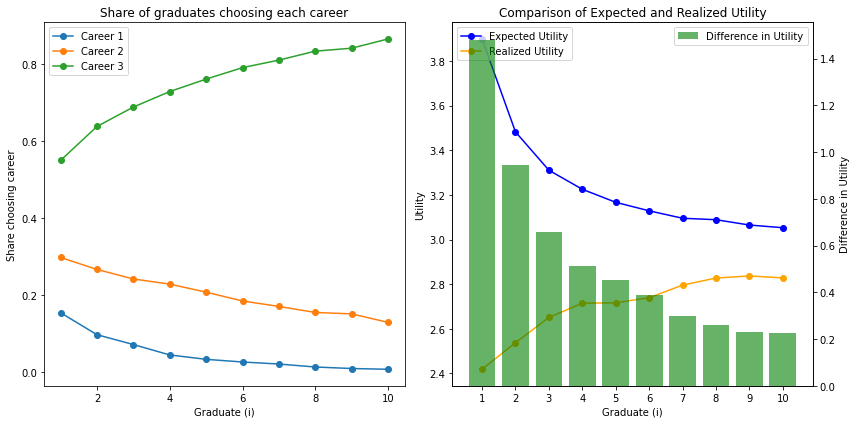

In [8]:
# We set the random seed for reproducibility
np.random.seed(1312)

# We generate all required random values upfront
friend_epsilons = np.random.normal(0, par.sigma, (par.K, par.N, max(par.F), par.J))
own_epsilons = np.random.normal(0, par.sigma, (par.K, par.N, par.J))

# Function to calculate utilities and choices
def simulate_career_choices(par, friend_epsilons, own_epsilons):
    # We initialize arrays to store the results
    shares = np.zeros((par.N, par.J))
    avg_subjective_expected_utility = np.zeros(par.N)
    avg_realized_utility = np.zeros(par.N)
    
    for k in range(par.K):  # Loop over each simulation
        for i in range(par.N):  # Loop over each graduate
            F_i = par.F[i]
            prior_expected_utilities = np.zeros(par.J)
            
            for j in range(par.J):  # Loop over each career track
                # We calculate friend noise terms for career track j
                friend_noise_terms = friend_epsilons[k, i, :F_i, j]
                prior_expected_utilities[j] = par.v[j] + np.mean(friend_noise_terms)
                
            # We determine the chosen career track based on prior expected utilities
            chosen_career = np.argmax(prior_expected_utilities)
            shares[i, chosen_career] += 1  # Update share for chosen career
            avg_subjective_expected_utility[i] += prior_expected_utilities[chosen_career]  # Update subjective expected utility
            avg_realized_utility[i] += par.v[chosen_career] + own_epsilons[k, i, chosen_career]  # Update realized utility
    
    # We average the results over all simulations
    shares /= par.K
    avg_subjective_expected_utility /= par.K
    avg_realized_utility /= par.K
    
    return shares, avg_subjective_expected_utility, avg_realized_utility

# We simulate career choices
# Assuming par, friend_epsilons, own_epsilons are defined correctly
shares, avg_subjective_expected_utility, avg_realized_utility = simulate_career_choices(par, friend_epsilons, own_epsilons)

# We calculate the difference in utility
difference_in_utility = avg_subjective_expected_utility - avg_realized_utility

# Visualization
graduates = np.arange(1, par.N + 1)

# We create a figure for plotting
plt.figure(figsize=(12, 6))

# Subplot 1: Share of graduates choosing each career as a line plot
plt.subplot(1, 2, 1)
for j in range(par.J):
    plt.plot(graduates, shares[:, j], marker='o', label=f'Career {j+1}')
plt.xlabel('Graduate (i)')
plt.ylabel('Share choosing career')
plt.legend()
plt.title('Share of graduates choosing each career')

# Subplot 2: Expected and realized utility as line plots, difference in utility as a bar plot with second y-axis
ax2 = plt.subplot(1, 2, 2)

# Line plot for expected utility
ax2.plot(graduates, avg_subjective_expected_utility, 'b-o', label='Expected Utility')

# Line plot for realized utility
ax2.plot(graduates, avg_realized_utility, 'orange', marker='o', linestyle='-', label='Realized Utility')

# We create a twin axes for the bar plot
ax3 = ax2.twinx()
ax3.bar(graduates, difference_in_utility, color='green', alpha=0.6, label='Difference in Utility')

# We set labels and title for the plot
ax2.set_xlabel('Graduate (i)')
ax2.set_ylabel('Utility')
ax2.set_title('Comparison of Expected and Realized Utility')
ax2.set_xticks(graduates)
ax2.legend(loc='upper left')
ax3.set_ylabel('Difference in Utility')
ax3.legend(loc='upper right')

# We adjust the layout and display the plot
plt.tight_layout()
plt.show()


The left figure illustrates the share of graduates choosing each career track as a function of the number of friends (graduates) $i$. It shows that with more friends (and hence more information), graduates are more likely to choose the career with the highest perceived utility (Career 3), while the shares for the less attractive careers (Careers 1 and 2) decrease. This pattern aligns with rational decision-making where better information leads to better choices.

The right figure illustrates the Average Subjective Expected Utility for each graduate $i$ as the number of friends increases. The average subjective expected utility decreases as the number of friends increases. This suggests that as graduates consult more friends, their expected utility estimates become more conservative or lower. Additionally, the right figure illustrates the Average Realized Utility for each graduate $i$ as the number of friends increases. The utility increases as the number of friends increases, suggesting that graduates who consult more friends make more informed decisions, resulting in higher realized utility. This trend aligns with the left figure, indicating that having more information leads graduates to choose careers that yield higher utility. Lastly, we see that the difference in expected and realized utility decreases the more information the graduates have.

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

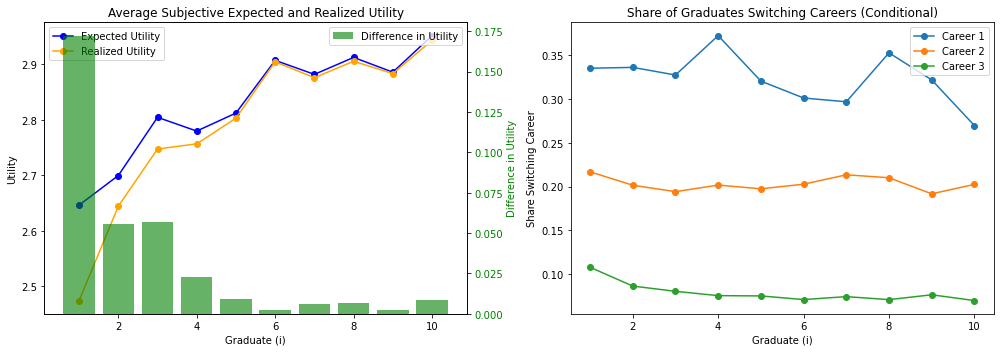

In [9]:
# We set the random seed for reproducibility
np.random.seed(1312)

# We initialize arrays to store results
chosen_careers = np.zeros((par.N, par.K), dtype=int)
prior_expectations = np.zeros((par.N, par.K))
realized_utilities = np.zeros((par.N, par.K))
new_chosen_careers = np.zeros((par.N, par.K), dtype=int)
new_prior_expectations = np.zeros((par.N, par.K))
new_realized_utilities = np.zeros((par.N, par.K))
switch_decisions = np.zeros((par.N, par.K), dtype=bool)

# Simulation
for k in range(par.K):
    for i in range(par.N):
        F_i = par.F[i]
        
        # We draw epsilon values for friends
        epsilon_friends = np.random.normal(0, par.sigma, (F_i, par.J))
        
        # We calculate prior expected utility for each career track
        prior_expected_utilities = par.v + np.mean(epsilon_friends, axis=0)
        
        # We draw epsilon values for the graduate
        epsilon_own = np.random.normal(0, par.sigma, par.J)
        
        # We choose the career track with the highest expected utility
        chosen_career = np.argmax(prior_expected_utilities)
        chosen_careers[i, k] = chosen_career
        
        # We store the prior expectation and realized utility of the chosen career
        prior_expectations[i, k] = prior_expected_utilities[chosen_career]
        realized_utilities[i, k] = par.v[chosen_career] + epsilon_own[chosen_career]
        
        # After one year, we recalculate the expected utilities including the switching cost
        new_prior_expected_utilities = prior_expected_utilities - par.sigma
        new_prior_expected_utilities[chosen_career] = realized_utilities[i, k]
        
        # We determine the new optimal career choice considering the switching cost
        new_chosen_career = np.argmax(new_prior_expected_utilities)
        new_chosen_careers[i, k] = new_chosen_career
        
        # We store the new prior expectation and realized utility
        new_prior_expectations[i, k] = new_prior_expected_utilities[new_chosen_career]
        if new_chosen_career == chosen_career:
            new_realized_utilities[i, k] = realized_utilities[i, k]
        else:
            new_realized_utilities[i, k] = par.v[new_chosen_career] + epsilon_own[new_chosen_career] - par.sigma
        
        # We store the switch decision
        switch_decisions[i, k] = (new_chosen_career != chosen_career)

# We calculate the average subjective expected utility and average realized utility for the new career choices
average_new_prior_expectations = np.mean(new_prior_expectations, axis=1)
average_new_realized_utilities = np.mean(new_realized_utilities, axis=1)

# We calculate the difference between expected and realized utility
difference_in_utility = average_new_prior_expectations - average_new_realized_utilities

# We calculate the share of graduates choosing to switch careers
switch_shares = np.mean(switch_decisions, axis=1)

# We calculate the conditional switch shares based on the initial career choice
conditional_switch_shares = np.zeros((par.N, par.J))
for i in range(par.N):
    for j in range(par.J):
        if np.sum(chosen_careers[i, :] == j) > 0:
            conditional_switch_shares[i, j] = np.mean(switch_decisions[i, chosen_careers[i, :] == j])

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Line plot for average subjective expected utility and average realized utility for the new career choices
x = np.arange(1, par.N + 1)

# Line plot for expected utility
ax[0].plot(x, average_new_prior_expectations, 'b-o', label='Expected Utility')

# Line plot for realized utility
ax[0].plot(x, average_new_realized_utilities, 'orange', marker='o', linestyle='-', label='Realized Utility')
ax[0].set_xlabel('Graduate (i)')
ax[0].set_ylabel('Utility')
ax[0].set_title('Average Subjective Expected and Realized Utility')
ax[0].legend()

# Bar plot for the difference in utility
ax_diff = ax[0].twinx()
ax_diff.bar(x, difference_in_utility, color='green', alpha=0.6, label='Difference in Utility')
ax_diff.set_ylabel('Difference in Utility', color='green')
ax_diff.tick_params(axis='y', labelcolor='green')

# We add a legend specifically for the bar plot of difference in utility
handles, labels = ax_diff.get_legend_handles_labels()
ax_diff.legend(handles=[handles[0]], labels=[labels[0]])

# Line plot for the share of graduates choosing to switch careers, conditional on initial career choice
for j in range(par.J):
    ax[1].plot(x, conditional_switch_shares[:, j], marker='o', label=f'Career {j + 1}')
ax[1].set_xlabel('Graduate (i)')
ax[1].set_ylabel('Share Switching Career')
ax[1].set_title('Share of Graduates Switching Careers (Conditional)')
ax[1].legend()

plt.tight_layout()
plt.show()


The left graph illustrates that both average subjective expected utility and average realized utility increase as graduates consult more friends. The gap between expected and realized utility is larger when there is less information available, particularly for graduates with fewer friends. This indicates that more information leads to better-informed career decisions, aligning expectations more closely with actual outcomes. The most significant improvements in utility occur with early information, demonstrating its high value in decision-making. As the number of friends increases, the utilities stabilize, showing diminishing returns from additional information.

The right graph shows that the highest share of graduates initially choosing Career 1 switch careers, with around 35-40% switching, despite the switching cost. Career 2 has a moderate switch rate of approximately 20%, while Career 3 has the lowest switch rate at approximately 10%. This indicates that Career 3 provides the highest intrinsic utility, making graduates less likely to switch.

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [10]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

In [11]:


# Defining function to find the points A, B, C and D
def find_ABCD(X, y):
    A = None
    B = None
    C = None
    D = None
    min_dist_A = float('inf')
    min_dist_B = float('inf')
    min_dist_C = float('inf')
    min_dist_D = float('inf')
    
    # We make a loop through each point (x1, x2) in X to find A, B, C and D
    for (x1, x2) in X:
        # Calculate distance between (x1, x2) and y
        dist = np.sqrt((x1 - y[0])**2 + (x2 - y[1])**2)
        
        # Finding the closest point satisfying our given conditions
        if x1 > y[0] and x2 > y[1] and dist < min_dist_A:
            A = (x1, x2)
            min_dist_A = dist
        
        if x1 > y[0] and x2 < y[1] and dist < min_dist_B:
            B = (x1, x2)
            min_dist_B = dist
        
        if x1 < y[0] and x2 < y[1] and dist < min_dist_C:
            C = (x1, x2)
            min_dist_C = dist
        
        if x1 < y[0] and x2 > y[1] and dist < min_dist_D:
            D = (x1, x2)
            min_dist_D = dist
    
    return A, B, C, D

# We find and define the points A, B, C and D
A, B, C, D = find_ABCD(X, y)

# We plot the figure
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], color='black', label='X')
plt.scatter(y[0], y[1], color='red', label='y', marker='x', s=100)

# Plotting A, B, C, D
points = [A, B, C, D]
labels = ['A', 'B', 'C', 'D']
colors = ['green', 'blue', 'orange', 'purple']

for i, point in enumerate(points):
    if point:
        plt.scatter(point[0], point[1], color=colors[i], label=labels[i], s=100)

# Drawing triangles ABC and CDA (under the condition that A, B, C and D are found)
if all(point is not None for point in [A, B, C, D]):
    plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'g-', label='ABC')
    plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], 'm-', label='CDA')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Random Points X, y and Triangles ABC and CDA')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

In the figure above, we have illustrated the set of random points in the unit square. For an arbitrary triangle ABC and a point y, we have defined the barycentric coordinates as depicted above. We have defined and computed the points A, B, C and D, and we have used the seed=2024. Visually, we see that the point $y$ is located within the triangle.

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [ ]:

# We use this function to compute the barycentric coordinates
def compute_barycentric_coordinates(y, A, B, C, D):
    # CChecking if any of A, B, C and D is 'None'
    if any(point is None for point in [A, B, C, D]):
        return None, None
    
    # Finding the coordinates of points A, B, C and D
    A1, A2 = A
    B1, B2 = B
    C1, C2 = C
    D1, D2 = D
    y1, y2 = y
    
    # Finding the Barycentric coordinates for triangle ABC
    denom_ABC = (B2 - C2)*(A1 - C1) + (C1 - B1)*(A2 - C2)
    if denom_ABC == 0:
        r1_ABC = 0
        r2_ABC = 0
    else:
        r1_ABC = ((B2 - C2)*(y1 - C1) + (C1 - B1)*(y2 - C2)) / denom_ABC
        r2_ABC = ((C2 - A2)*(y1 - C1) + (A1 - C1)*(y2 - C2)) / denom_ABC
    r3_ABC = 1 - r1_ABC - r2_ABC
    
    # Finding the Barycentric coordinates for triangle CDA
    denom_CDA = (D2 - A2)*(C1 - A1) + (A1 - D1)*(C2 - A2)
    if denom_CDA == 0:
        r1_CDA = 0
        r2_CDA = 0
    else:
        r1_CDA = ((D2 - A2)*(y1 - A1) + (A1 - D1)*(y2 - A2)) / denom_CDA
        r2_CDA = ((A2 - C2)*(y1 - A1) + (C1 - A1)*(y2 - A2)) / denom_CDA
    r3_CDA = 1 - r1_CDA - r2_CDA
    
    return (r1_ABC, r2_ABC, r3_ABC), (r1_CDA, r2_CDA, r3_CDA)

# Defining a function to determine which triangle y is inside
def point_inside_triangle(y, A, B, C, D):
    # Computing Barycentric coordinates
    bary_ABC, bary_CDA = compute_barycentric_coordinates(y, A, B, C, D)
    
    if bary_ABC is not None:
        # Checking if y is inside triangle ABC
        if all(0 <= r <= 1 for r in bary_ABC) and np.isclose(sum(bary_ABC), 1):
            return "ABC"
    
    if bary_CDA is not None:
        # Checking if y is inside triangle CDA
        if all(0 <= r <= 1 for r in bary_CDA) and np.isclose(sum(bary_CDA), 1):
            return "CDA"
    
    return "NaN"

# Then, we can determine which triangle y is inside
triangle = point_inside_triangle(y, A, B, C, D)

# Printing the results
print(f"Point y = {y} is inside triangle {triangle}.")

# Finally, we print the Barycentric coordinates if y is inside a triangle
if triangle in ['ABC', 'CDA']:
    bary_ABC, bary_CDA = compute_barycentric_coordinates(y, A, B, C, D)
    if triangle == 'ABC':
        print(f"Barycentric coordinates for triangle ABC: {bary_ABC}")
    elif triangle == 'CDA':
        print(f"Barycentric coordinates for triangle CDA: {bary_CDA}")


We find the coordinates for y: $y = [0.20901926, 0.37774759]$. We find that y is thus inside the triangle ABC, using the defined functions. The Barycentric coordinates for triangle ABC are found using the formulas for the coordinates $r_1,\; r_2\;\text{and}\; r_3$.

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [ ]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [ ]:

# Using function to compute approximation of f(y)
def approximate_f(y, A, B, C, D, bary_ABC, bary_CDA):
    # Values of f at A, B, C, D
    fA = f(A) if A is not None else None
    fB = f(B) if B is not None else None
    fC = f(C) if C is not None else None
    fD = f(D) if D is not None else None
    
    # Check if any f value is None
    if any(value is None for value in [fA, fB, fC, fD]):
        return None, None
    
    # Check if barycentric coordinates are None
    if bary_ABC is None or bary_CDA is None:
        return None, None
    
    # Compute approximation using barycentric coordinates
    f_y_ABC = bary_ABC[0] * fA + bary_ABC[1] * fB + bary_ABC[2] * fC
    f_y_CDA = bary_CDA[0] * fC + bary_CDA[1] * fD + bary_CDA[2] * fA
    
    return f_y_ABC, f_y_CDA

# Computing approximation of f(y)
f_y_ABC, f_y_CDA = approximate_f(y, A, B, C, D, bary_ABC, bary_CDA)

# Computing true value of f(y)
true_f_y = f(y)

# Printing the results
print(f"True value of f(y): {true_f_y}")
print(f"Approximation of f(y) using triangle ABC: {f_y_ABC}")
print(f"Approximation of f(y) using triangle CDA: {f_y_CDA}")

The approximation of $f(y)$ using triangles $ABC$ and $CDA$ leverages barycentric coordinates to interpolate the function values at A, B, C and D relative to y's position within these triangles. We find that the true value of $f(y)=0.0789565216259594$, using the function for f and y's coordinates. The approximations of $f(y)$ based on the triangles ABC and CDA are equal to $f(y)_{ABC}=0.08405201731052576$ and $f(y)_{CDA}=0.08522314835313917$, where the approximation based on the triangle ABC is closer to the true value. 

Barycentric Coordinates measure how $y$ is positioned relative to $A, B$, and $C$ in triangle $ABC$. Inside the triangle, these coordinates directly influence the interpolation of $f(y)$. The interpolation formula $f(y) \approx r1_{ABC} \cdot f(A) + r2_{ABC} \cdot f(B) + r3_{ABC} \cdot f(C)$ uses $f$'s values at $A, B$, and $C$, providing a close approximation due to $y$'s proximity to these points. Since $y$ is within $ABC$, this method leverages nearby points to compute $f(y)$, yielding an approximation closer to $f(y) = y_1 \cdot y_2$.

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [ ]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [ ]:

# Iterating over points in Y
for y in Y:
    # Finding points A, B, C and D
    A, B, C, D = find_ABCD(X, y)
    
    # Computing Barycentric coordinates
    bary_ABC, bary_CDA = compute_barycentric_coordinates(y, A, B, C, D)
    
    # Computing approximation of f(y)
    f_y_ABC, f_y_CDA = approximate_f(y, A, B, C, D, bary_ABC, bary_CDA)
    
    # Computing the true value of f(y)
    true_f_y = round(f(y),2)
    
    # Printing results
    print(f"Point y = {y}")
    print(f"True value of f(y): {true_f_y}")
    if bary_ABC is not None:
        print(f"Approximation of f(y) using triangle ABC: {f_y_ABC}")
    else:
        print("No suitable triangle ABC found.")
    if bary_CDA is not None:
        print(f"Approximation of f(y) using triangle CDA: {f_y_CDA}")
    else:
        print("No suitable triangle CDA found.")
    print()

In [ ]:
# Defining the set Y with labels - here with labels for the plot
Y = [((0.2, 0.2), 'y1'),((0.8, 0.8), 'y2'), ((0.8, 0.2), 'y3'), ((0.5, 0.5), 'y4')]

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], color='black', label='X')

# Lists to collect handles for the legend
legend_handles = []

# Iterating over points in Y
for y, label in Y:
    # Finding points A, B, C and D
    A, B, C, D = find_ABCD(X, y)
    
    # Compute Barycentric coordinates
    bary_ABC, bary_CDA = compute_barycentric_coordinates(y, A, B, C, D)
    
    # Plot y with unique colors
    color = plt.cm.tab10(hash(label) % 10)  # Assign unique color based on label
    legend_handles.append(plt.scatter(y[0], y[1], color=color, label=label, marker='x', s=100))
    
    # Plotting A, B, C and D
    points = [A, B, C, D]
    labels = ['A', 'B', 'C', 'D']
    colors = ['green', 'blue', 'orange', 'purple']
    
    for i, point in enumerate(points):
        if point:
            plt.scatter(point[0], point[1], color=colors[i], label=None, s=100)
    
    # Drawing triangles ABC and CDA if A, B, C, D are found
    if all(point is not None for point in [A, B, C, D]):
        plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'g-', label=None)
        plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], 'm-', label=None)

# Show legend only for points y1 to y4
plt.legend(handles=legend_handles, loc='upper right', title='Points Y')

# Adjusting plot limits, labels, and titles
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(f'Random Points X and Triangles ABC, CDA for Points in Y')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

The results highlight the effectiveness of triangle-based interpolation for approximating $f(y)$ in a 2D space. Points where triangles $ABC$ and $CDA$ are formed generally yield close approximations to the true values of $f(y)$, demonstrating the method's accuracy. For example, at point $y = (0.2, 0.2)$, the approximation using triangle $ABC$ ($0.04032631372248057$) is very close to the true value of $0.04000000000000001$ because of the fact that point y lies within triangle $ABC$ and benefits from a precise interpolation. In contrast, at $y = (0.8, 0.8)$, where no suitable triangles could be formed, accurate approximations were not possible, underscoring the method's dependency on the availability of neighboring points for triangulation.